<a href="https://colab.research.google.com/github/Prakrut/Fraud_Detection/blob/master/Code/CreditCardFraudDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries 

In [40]:
# Python
import pandas as pd
import sys, os
import numpy as np 
import time


# Third-Party
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Custom
from utility import piechart, barchart_categorical, barchart_continuous

# Options
pd.set_option('max_columns',500)
pd.set_option('max_rows',50)


### Data 

In [41]:
path = '../Data'
for i in os.listdir(path):
    print (i)

sample_submission.csv
test_identity.csv
test_transaction.csv
train_identity.csv
train_transaction.csv


In [42]:
train_identity = pd.read_csv(path + '/train_identity.csv')
train_transaction = pd.read_csv(path + '/train_transaction.csv')

In [43]:
train = train_transaction.merge(train_identity,
                                on = 'TransactionID',
                                how = 'left'
                               )

In [44]:
test = pd.merge(pd.read_csv(path + '/test_transaction.csv'),
                pd.read_csv(path + '/test_identity.csv'),
                on = 'TransactionID',
                how = 'left'
               )

In [10]:
test.shape, train.shape

((506691, 433), (590540, 434))

In [45]:
test.columns = test.columns.map(lambda x : x.replace('-','_'))


In [7]:
set(train.columns) - set(test.columns)

{'isFraud'}

In [51]:
print(len(train.columns.values))

train.columns.values

434


array(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain',
       'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
       'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4',
       'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14',
       'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1',
       'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29',
       'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38',
       'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47',
       'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56',
       'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65',
       'V66', 'V6

#### Missing Dataset 

In [46]:
data_null = train.isnull().sum()/len(train) * 100
data_null = data_null.sort_values(ascending=False)[:500]

# data_null = data_null.drop(data_null[data_null == 0].index).sort_values(ascending=False)[:500]
missing_data = pd.DataFrame({'Missing Ratio': data_null})
missing_data

,Missing Ratio
id_24,99.196159
id_25,99.130965
id_07,99.127070
id_08,99.127070
id_21,99.126393
...,...
C11,0.000000
C12,0.000000
C13,0.000000
C14,0.000000


#### Time data check 

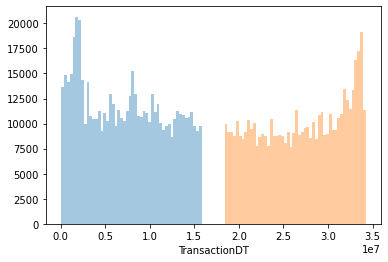

In [34]:
sns.distplot(train.TransactionDT, label = 'Train', kde = False)
sns.distplot(test.TransactionDT, label = 'Test', kde = Falsea)
plt.show()

In [48]:
# TransactionDT seems to be in seconds from epoch; dont know what epoch is; see below for # of days in train and test
print("Training Dataset length in days: {:.0f}".\
      format((train.TransactionDT.max() - train.TransactionDT.min())/(3600*24)))

print("Test Dataset length in days: {:.0f}".\
      format((test.TransactionDT.max() - test.TransactionDT.min())/(3600*24)))

Training Dataset length in days: 182
Test Dataset length in days: 183


In [44]:
time.ctime(time.time() + test.TransactionDT.max())

'Wed Aug 25 12:01:10 2021'

In [52]:
train.nunique()

TransactionID     590540
isFraud                2
TransactionDT     573349
TransactionAmt     20902
ProductCD              5
                   ...  
id_36                  2
id_37                  2
id_38                  2
DeviceType             2
DeviceInfo          1786
Length: 434, dtype: int64

In [31]:
cat_vars = ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2',  'P_emaildomain',
       'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9','id_12', 'id_13', 'id_14', 'id_15', 'id_16',
       'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23',
       'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30',
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37',
       'id_38', 'DeviceType', 'DeviceInfo']

In [32]:
len(cat_vars)

49

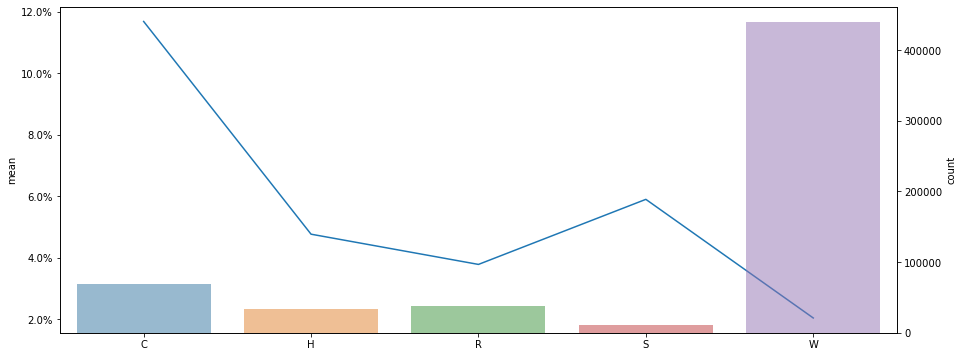

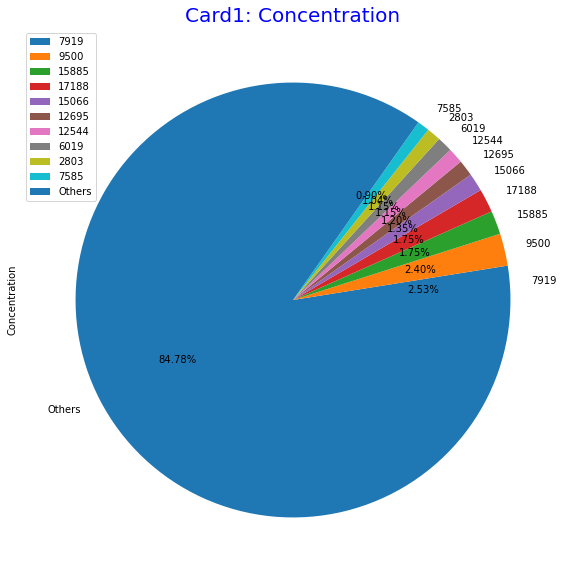

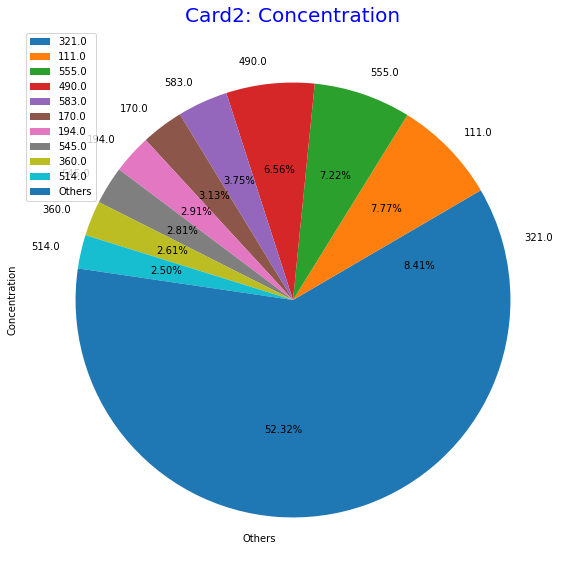

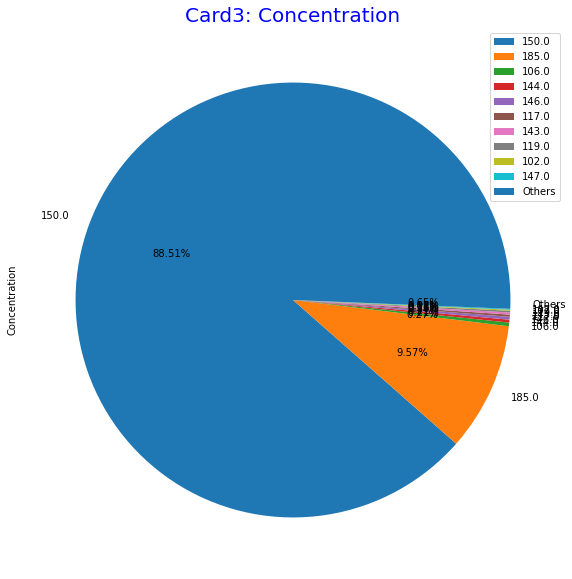

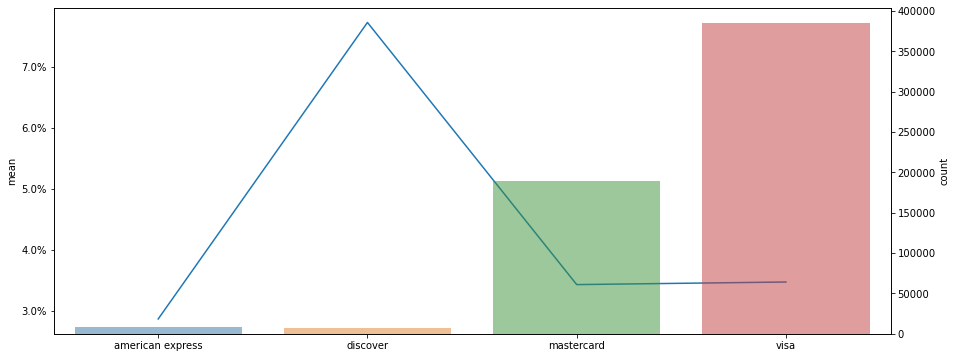

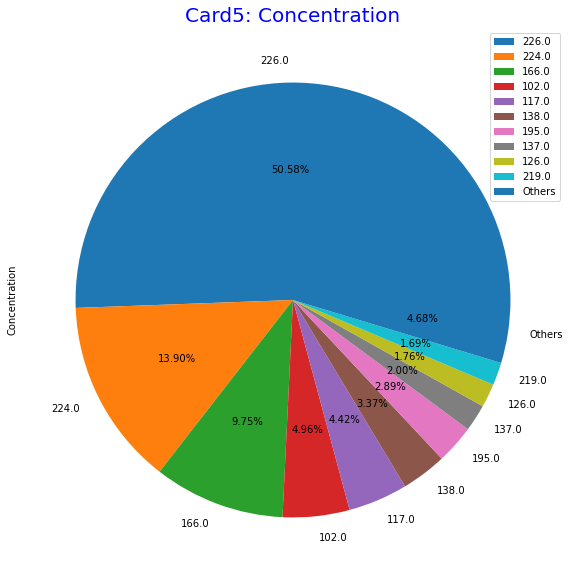

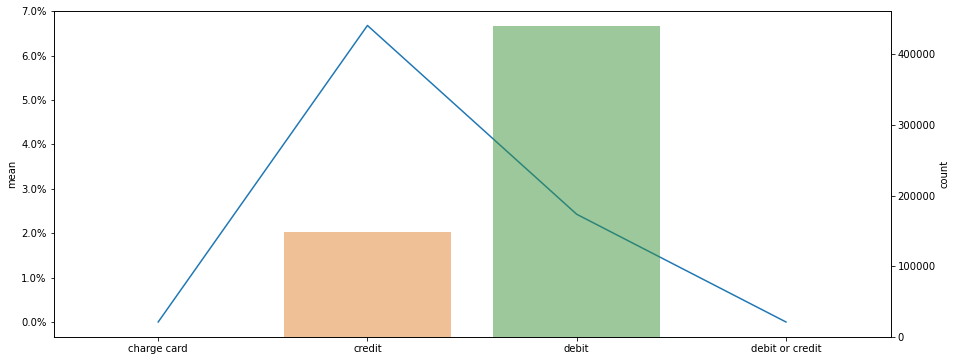

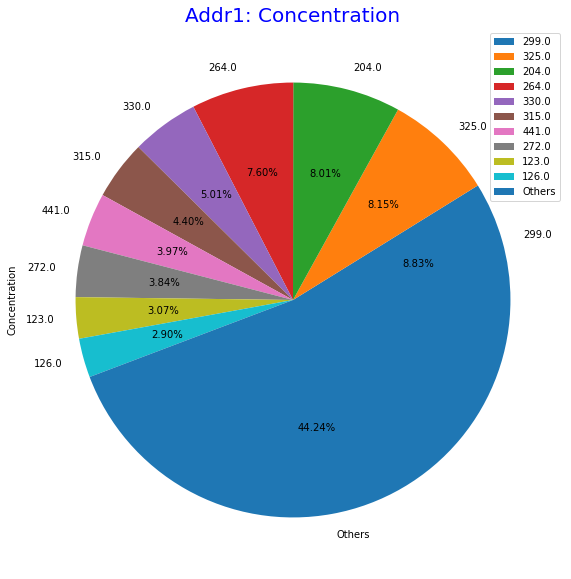

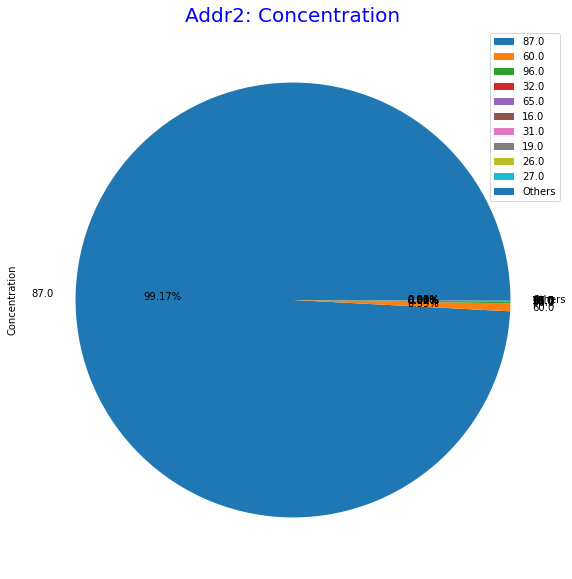

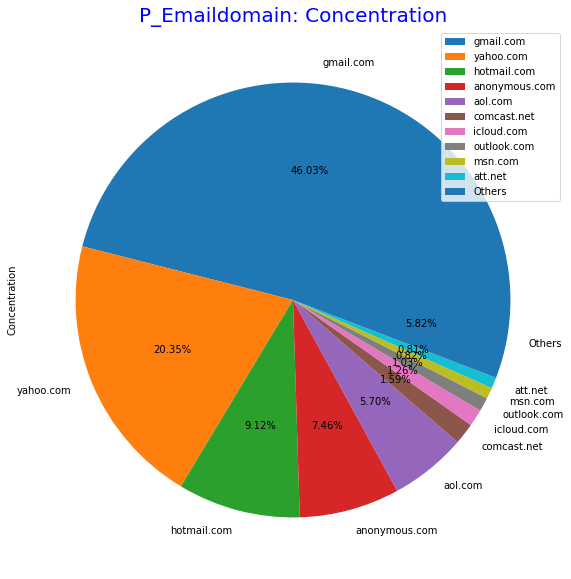

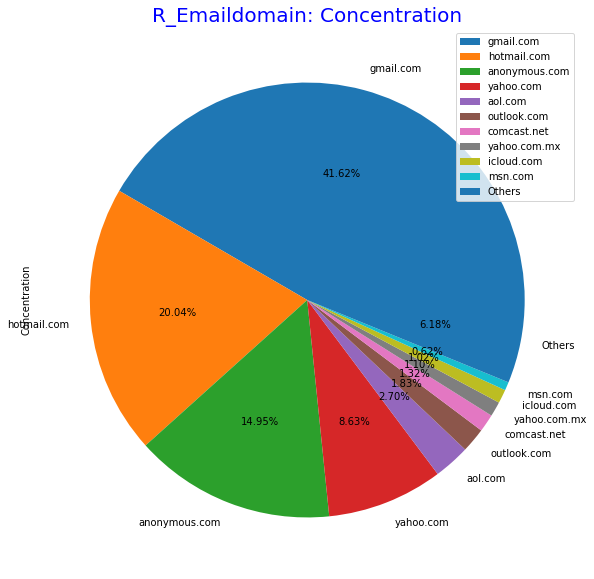

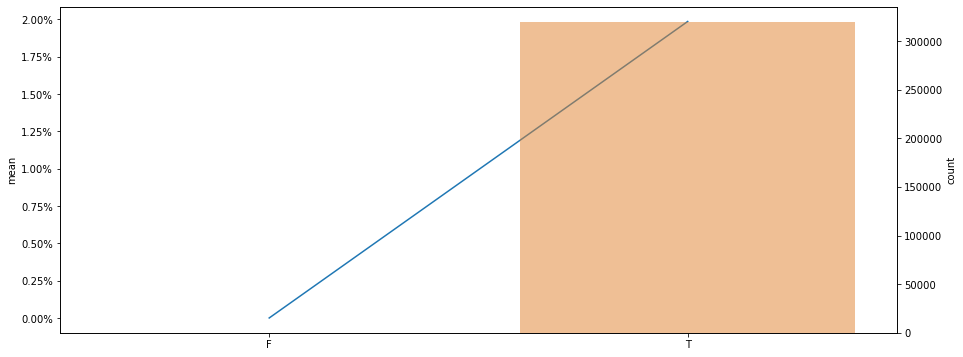

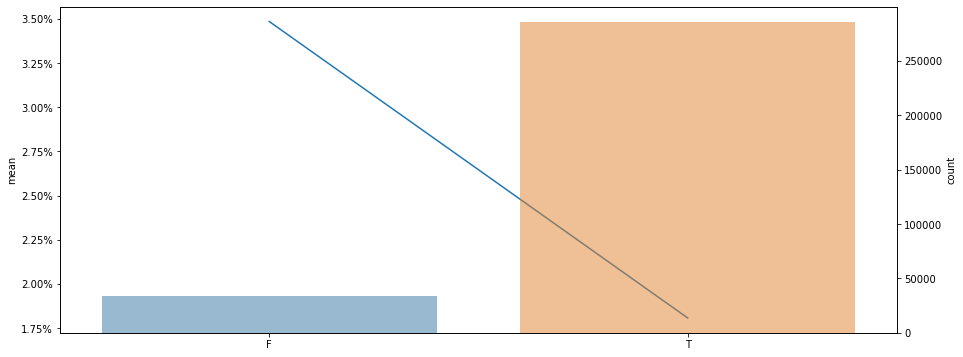

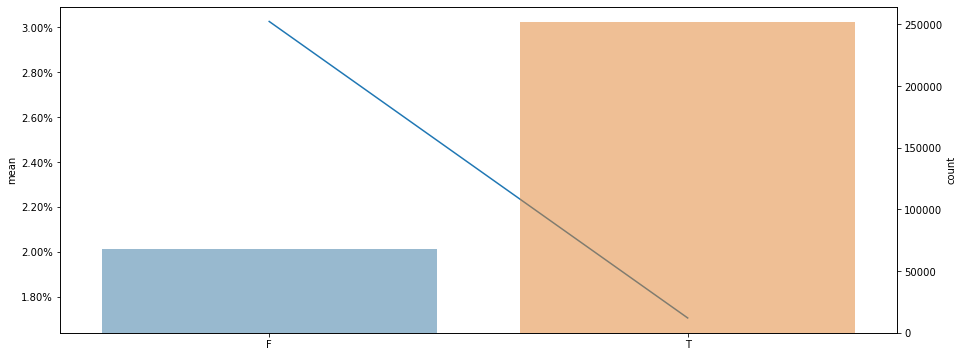

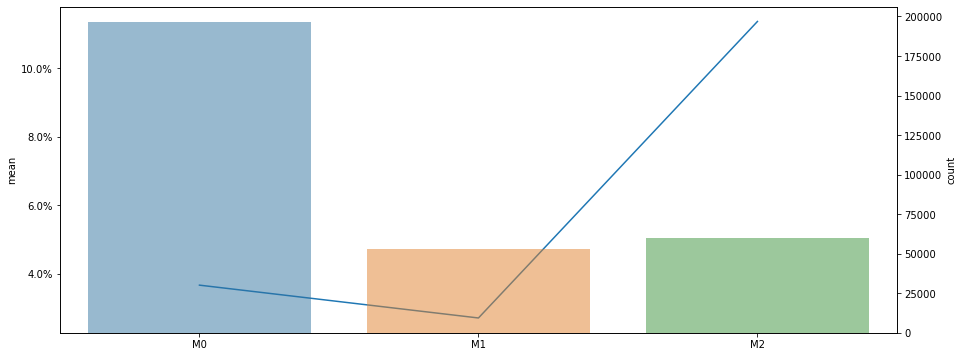

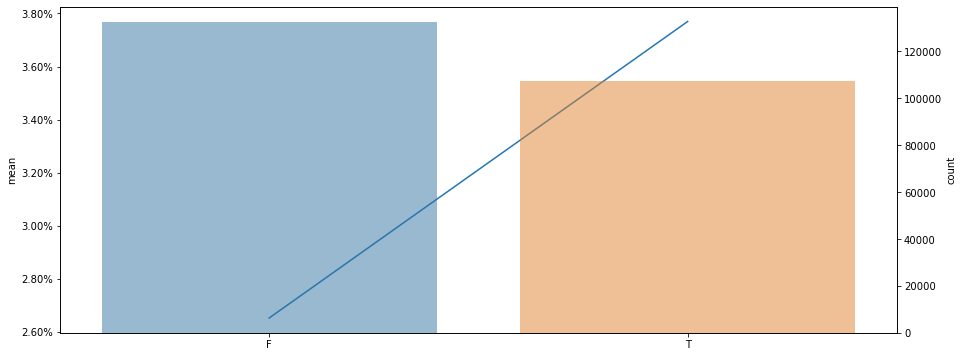

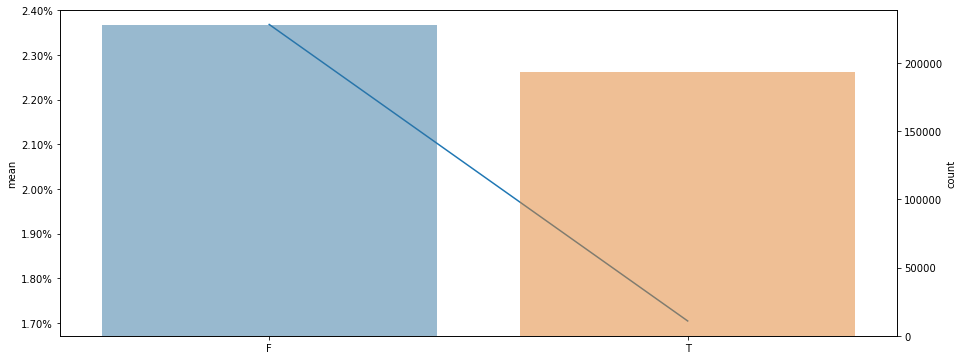

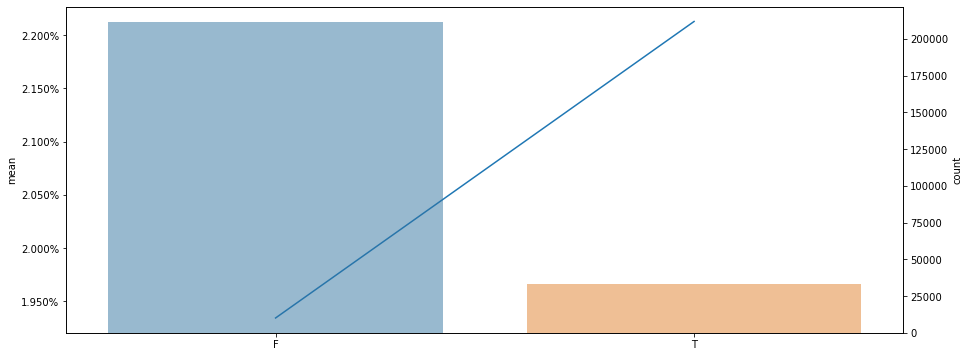

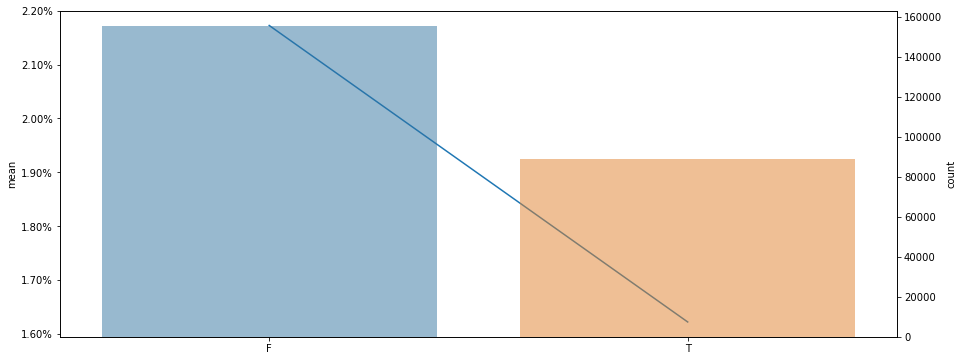

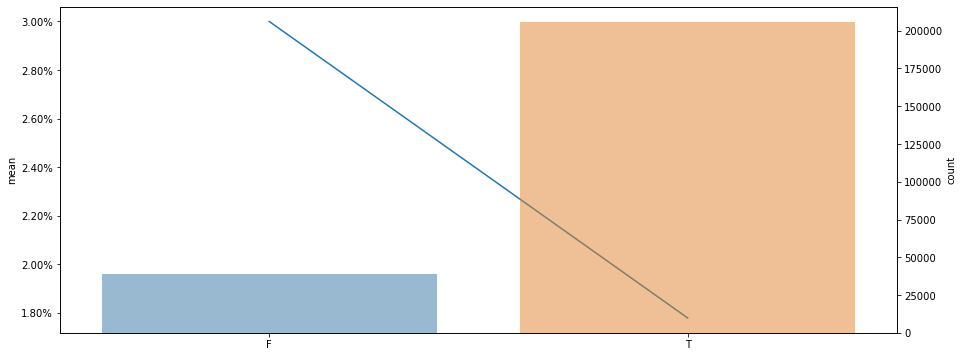

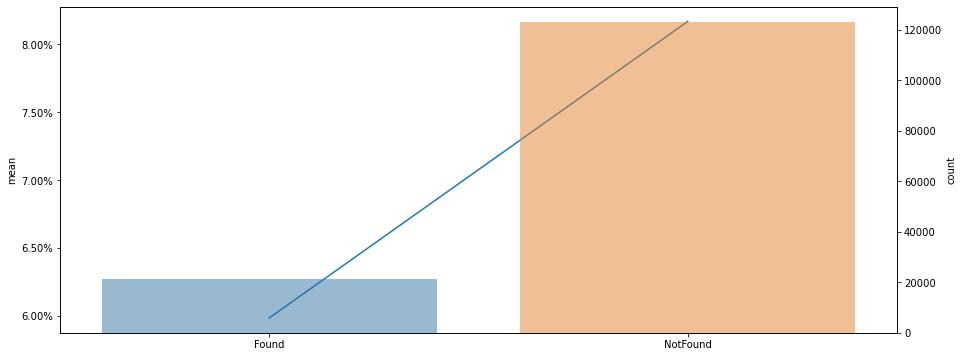

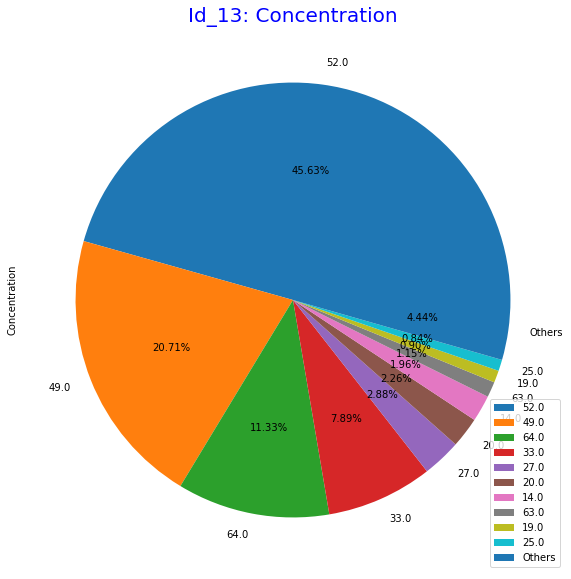

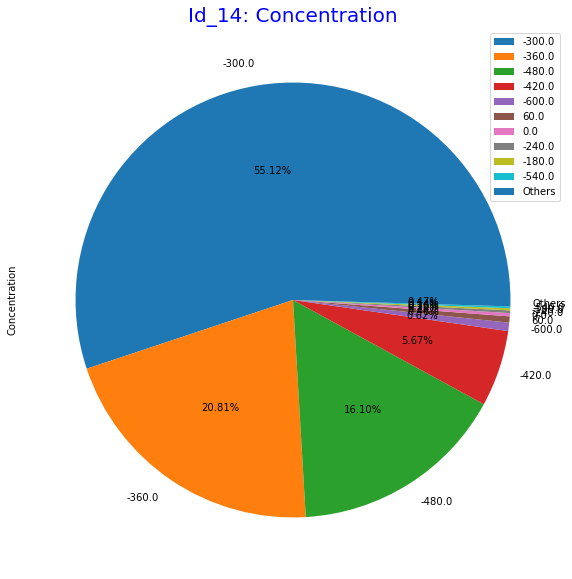

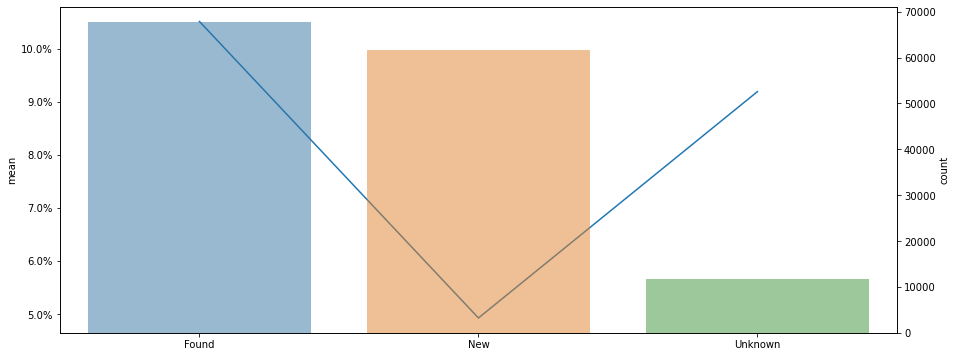

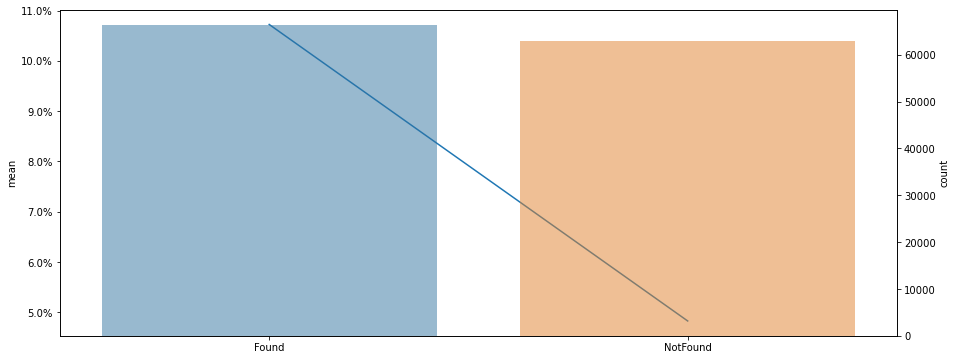

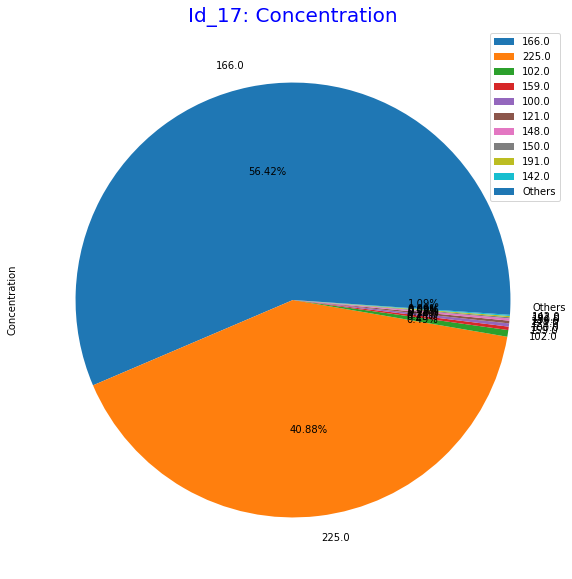

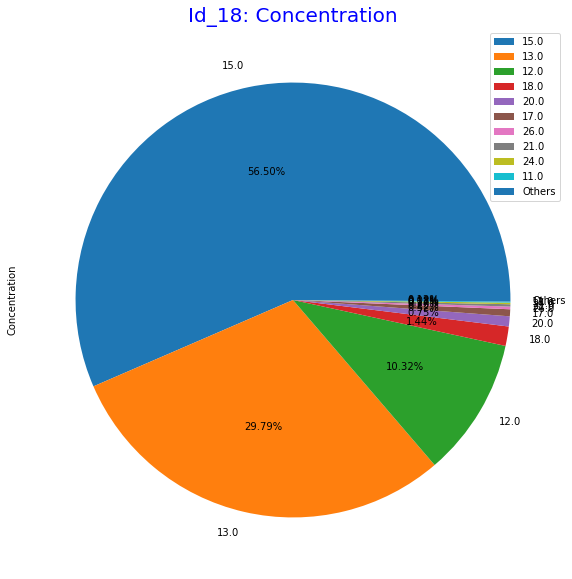

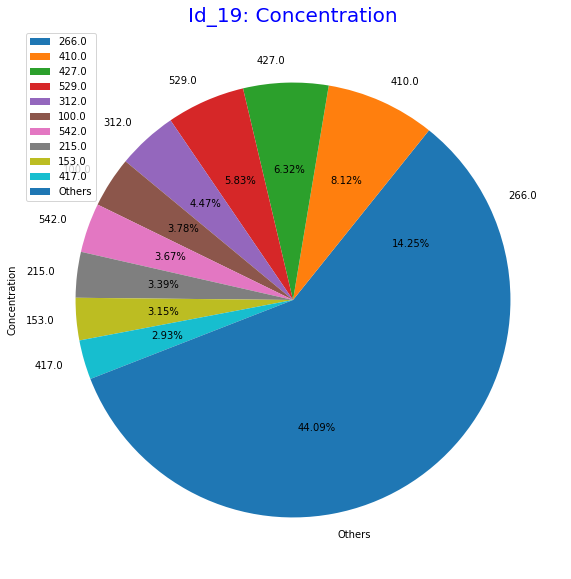

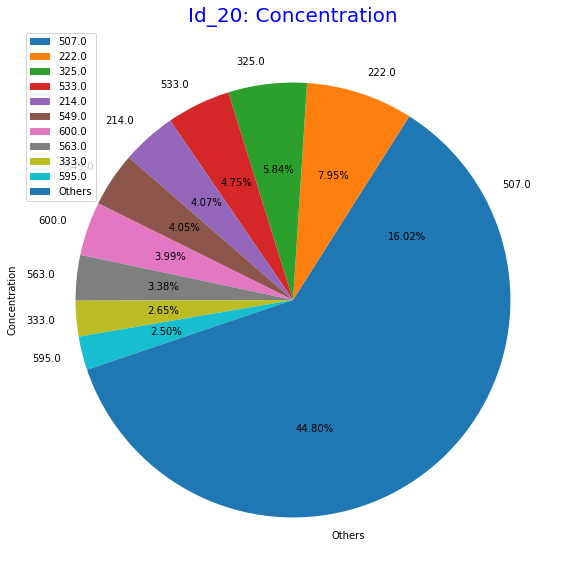

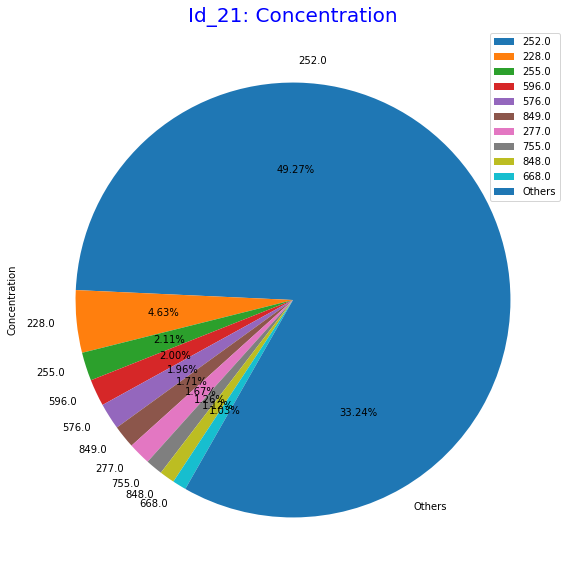

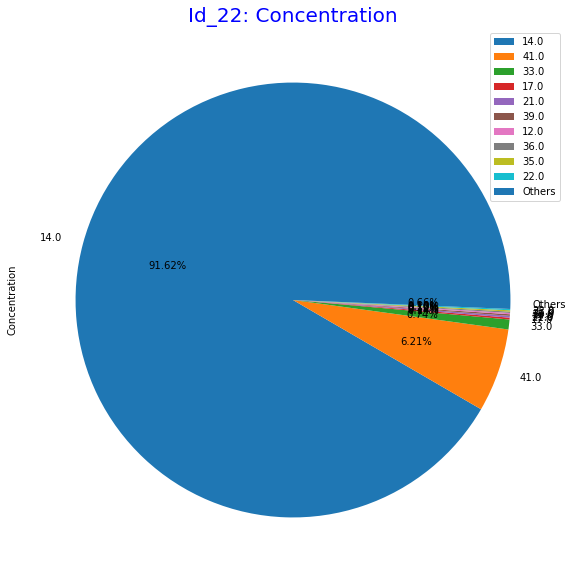

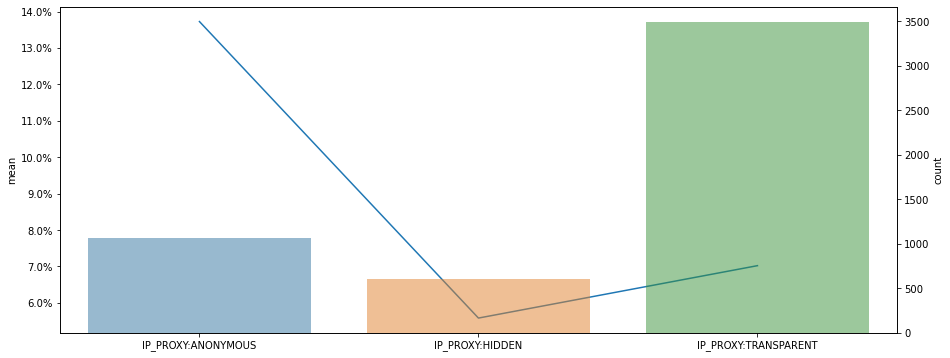

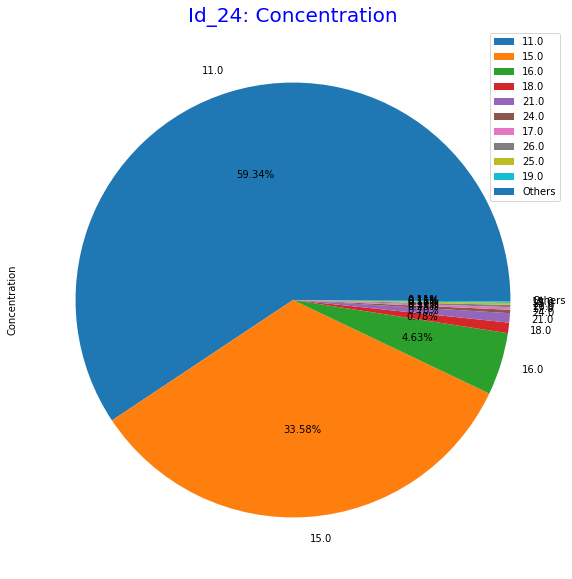

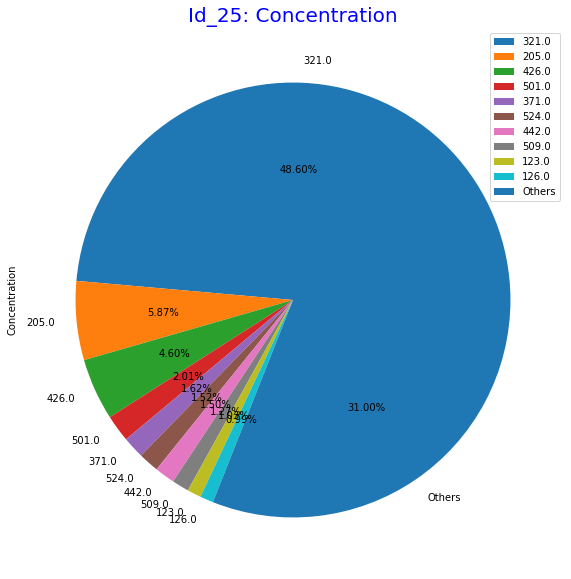

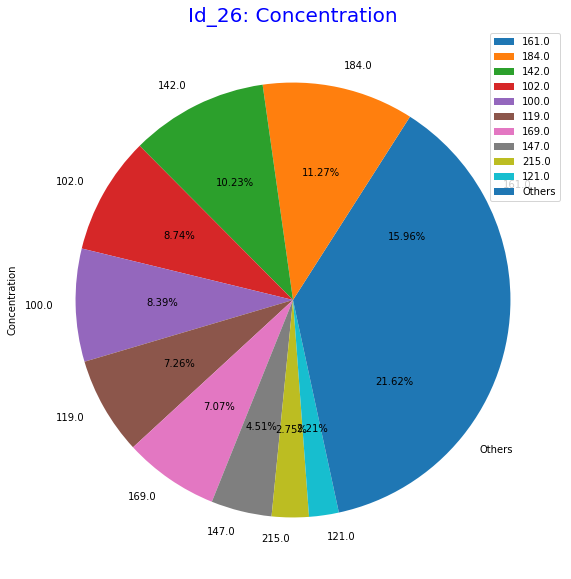

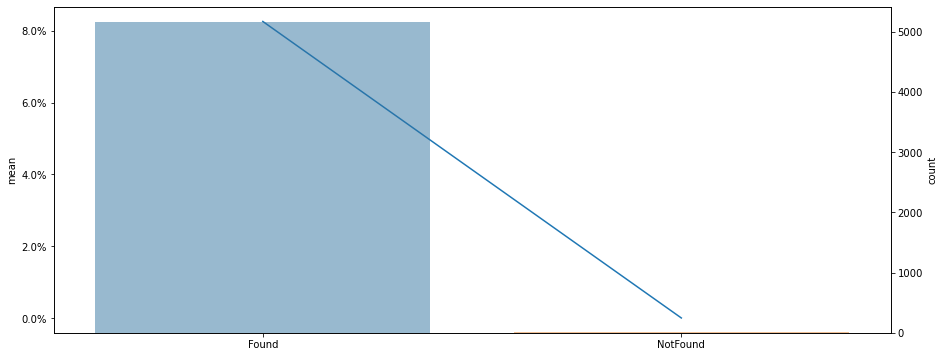

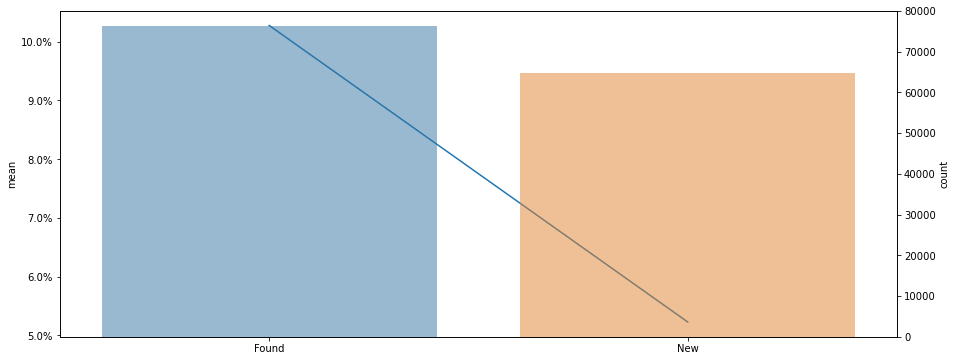

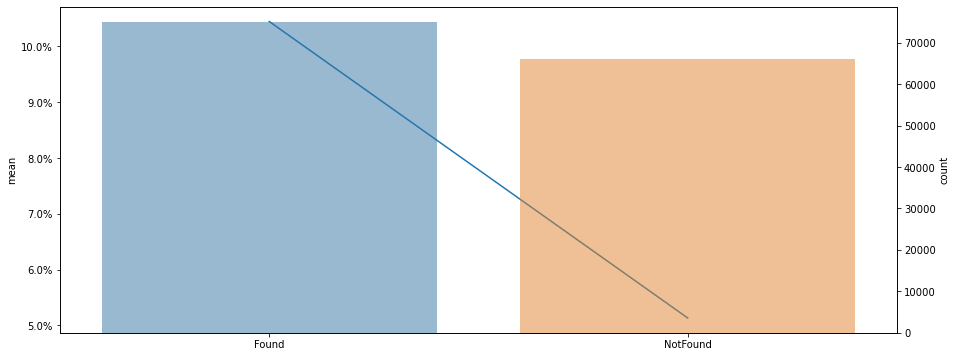

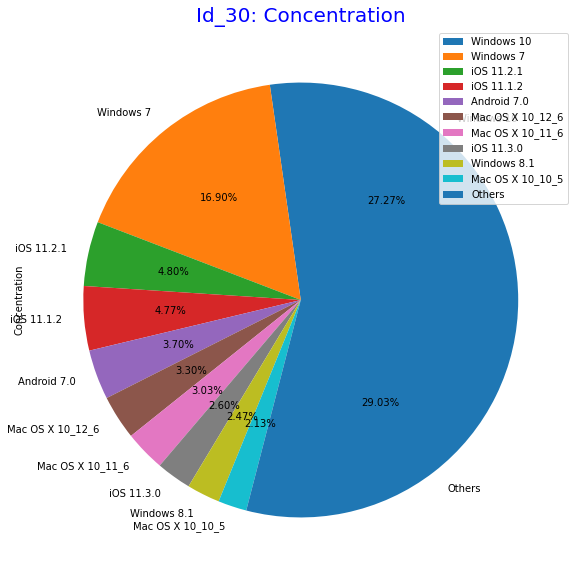

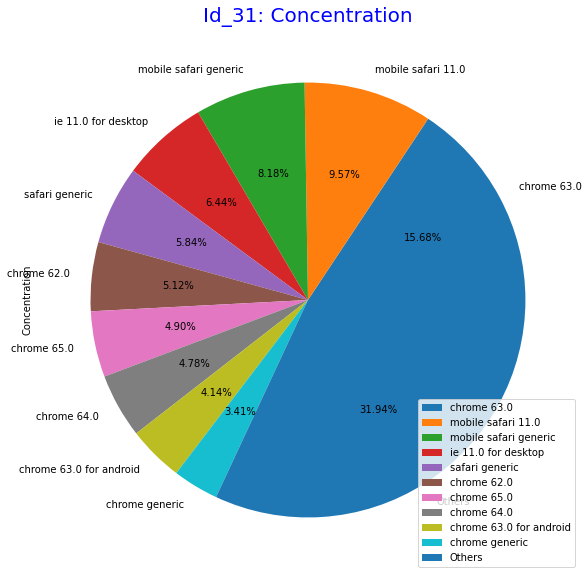

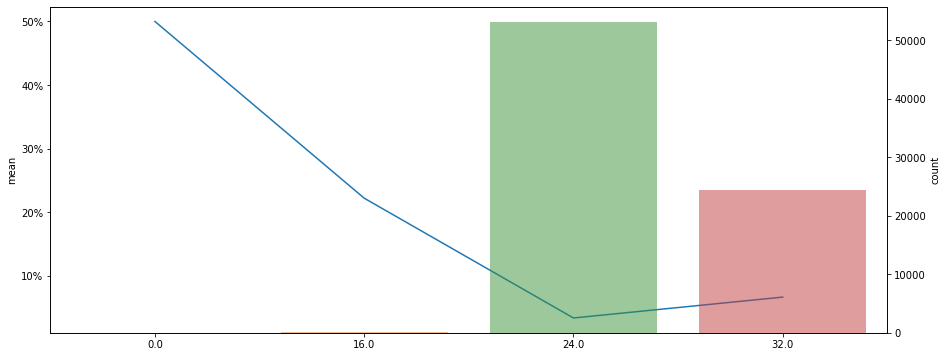

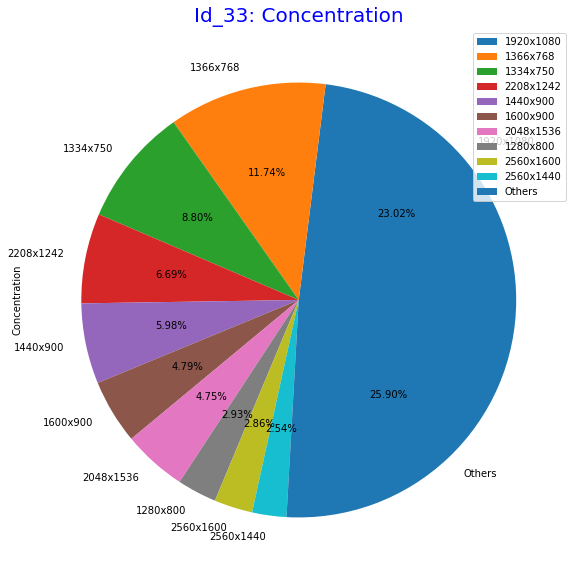

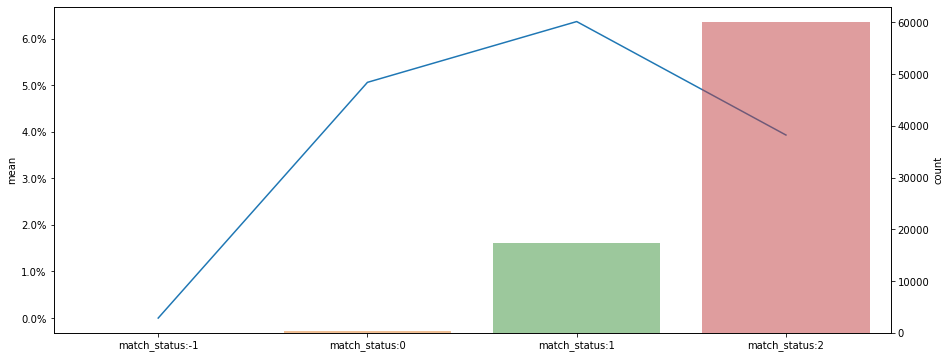

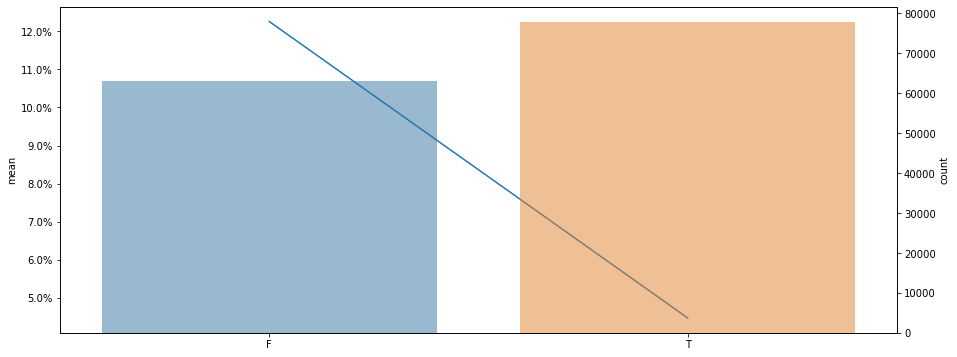

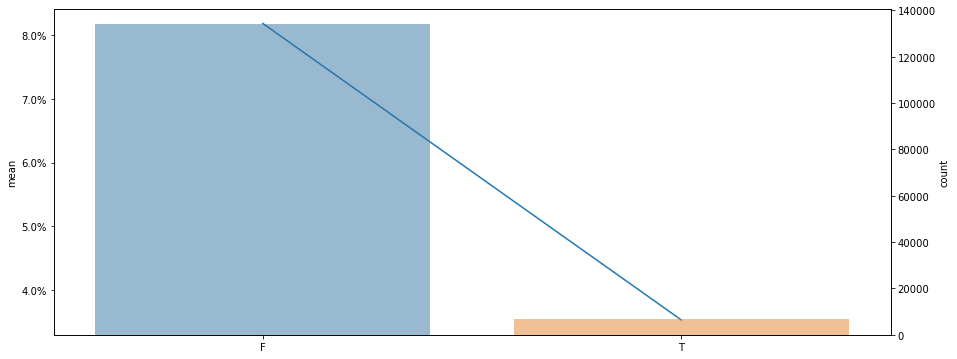

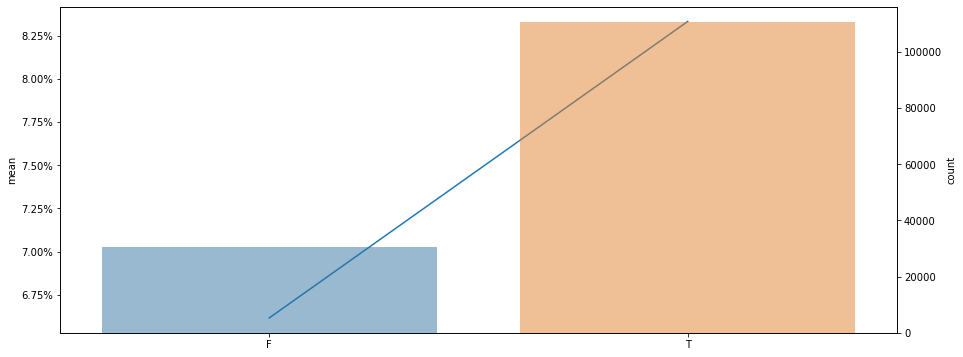

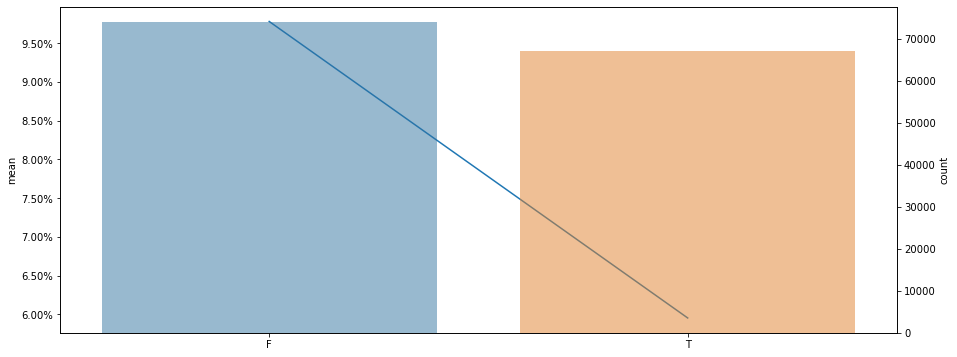

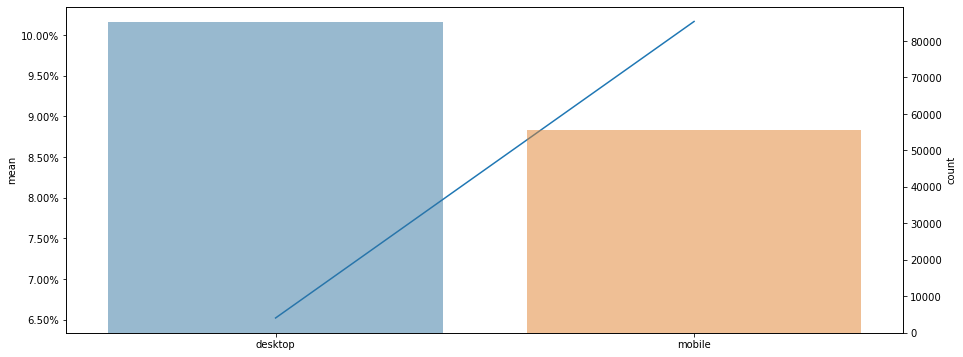

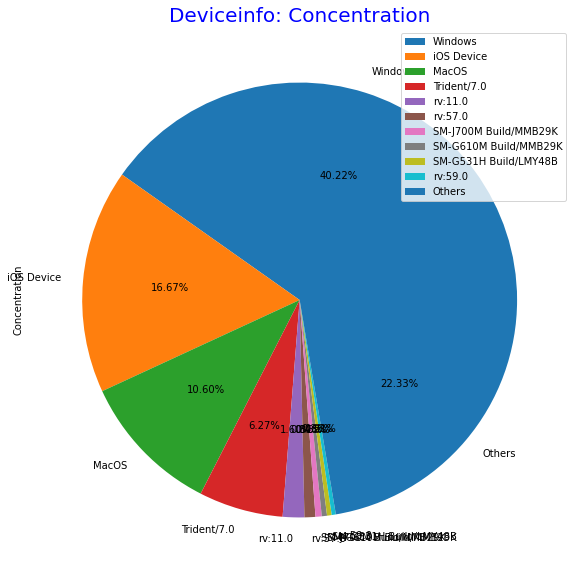

In [35]:
for i in cat_vars:
#     piechart(train, i, 5, 'TransactionID')
    if len(train[i].unique()) <= 10:
        barchart_categorical(train, i, 'isFraud')
    else:
        piechart(train, i, 10, 'TransactionID')

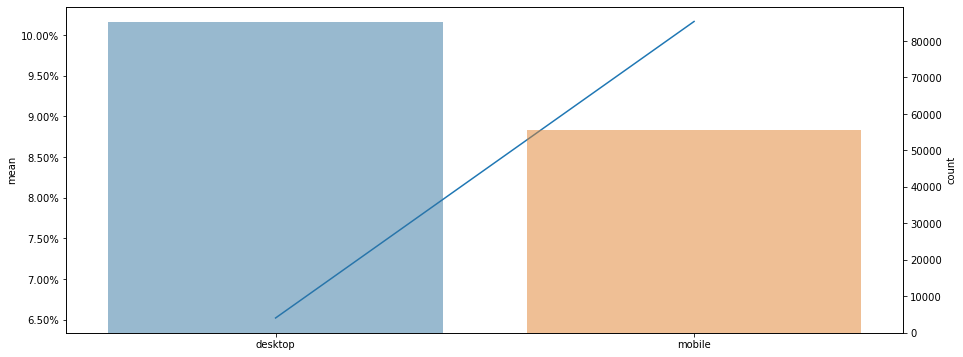

In [19]:
barchart_categorical(train, 'DeviceType', 'isFraud')

In [27]:
train.P_emaildomain.unique()

array([nan, 'gmail.com', 'outlook.com', 'yahoo.com', 'mail.com',
       'anonymous.com', 'hotmail.com', 'verizon.net', 'aol.com', 'me.com',
       'comcast.net', 'optonline.net', 'cox.net', 'charter.net',
       'rocketmail.com', 'prodigy.net.mx', 'embarqmail.com', 'icloud.com',
       'live.com.mx', 'gmail', 'live.com', 'att.net', 'juno.com',
       'ymail.com', 'sbcglobal.net', 'bellsouth.net', 'msn.com', 'q.com',
       'yahoo.com.mx', 'centurylink.net', 'servicios-ta.com',
       'earthlink.net', 'hotmail.es', 'cfl.rr.com', 'roadrunner.com',
       'netzero.net', 'gmx.de', 'suddenlink.net', 'frontiernet.net',
       'windstream.net', 'frontier.com', 'outlook.es', 'mac.com',
       'netzero.com', 'aim.com', 'web.de', 'twc.com', 'cableone.net',
       'yahoo.fr', 'yahoo.de', 'yahoo.es', 'sc.rr.com', 'ptd.net',
       'live.fr', 'yahoo.co.uk', 'hotmail.fr', 'hotmail.de',
       'hotmail.co.uk', 'protonmail.com', 'yahoo.co.jp'], dtype=object)

In [ ]:
train.value_counts()

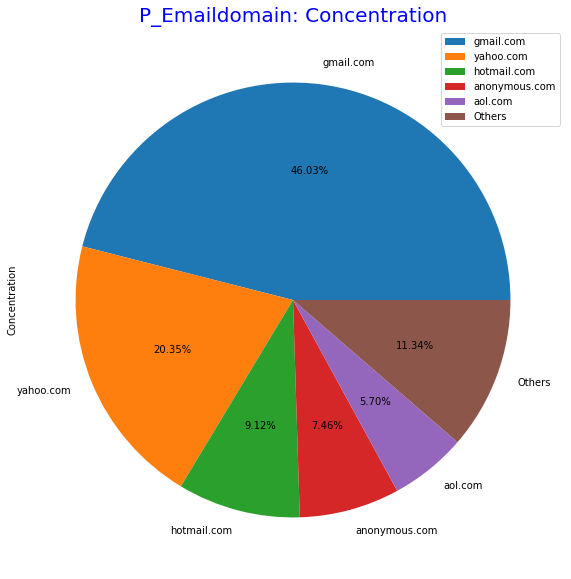

,Count,Concentration
P_emaildomain,,
gmail.com,"228,355",46.03%
yahoo.com,"100,934",20.35%
hotmail.com,"45,250",9.12%
anonymous.com,"36,998",7.46%
aol.com,"28,289",5.70%
Others,"56,258",11.34%


In [28]:
piechart(train, 'P_emaildomain',5,'TransactionID')

In [ ]:
missing_data